**1-  IMPORTS** 

First we imported all the necesary libraries for the project.

In [9]:
# Importing libraries
import pandas as pd
import numpy as np
from google.colab import drive
import copy 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import recall_score, precision_score, f1_score, classification_report, roc_curve, roc_auc_score, accuracy_score, confusion_matrix
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

**2 -  LOAD THE DATASET**

In this section, we loaded our train and test dataset from csv files source, and displayed the data and the shape of the dataframe.

In [10]:
from google.colab import drive
drive.mount('/content/gdrive/')
# load data 
train_auto = pd.read_csv("/content/gdrive/My Drive/Datasets/test_technique/train_auto.csv", sep=",",index_col="INDEX")
test_auto = pd.read_csv("/content/gdrive/My Drive/Datasets/test_technique/test_auto.csv", sep=",",index_col="INDEX")

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [11]:
# print the train dataframe
train_auto.head(3)

,TARGET_FLAG,TARGET_AMT,KIDSDRIV,AGE,HOMEKIDS,YOJ,INCOME,PARENT1,HOME_VAL,MSTATUS,SEX,EDUCATION,JOB,TRAVTIME,CAR_USE,BLUEBOOK,TIF,CAR_TYPE,RED_CAR,OLDCLAIM,CLM_FREQ,REVOKED,MVR_PTS,CAR_AGE,URBANICITY
INDEX,,,,,,,,,,,,,,,,,,,,,,,,,
1,0,0.0,0,60.0,0,11.0,"$67,349",No,$0,z_No,M,PhD,Professional,14,Private,"$14,230",11,Minivan,yes,"$4,461",2,No,3,18.0,Highly Urban/ Urban
2,0,0.0,0,43.0,0,11.0,"$91,449",No,"$257,252",z_No,M,z_High School,z_Blue Collar,22,Commercial,"$14,940",1,Minivan,yes,$0,0,No,0,1.0,Highly Urban/ Urban
4,0,0.0,0,35.0,1,10.0,"$16,039",No,"$124,191",Yes,z_F,z_High School,Clerical,5,Private,"$4,010",4,z_SUV,no,"$38,690",2,No,3,10.0,Highly Urban/ Urban


In [12]:
# shape of the train dataset before the preprocessing (8161 observations and 25 variables)
print(train_auto.shape)

(8161, 25)


**3 -  PRETREATMENT**

In [13]:
def set_type(df,column,type):
  df[column] = df[column].astype(type)


# we will convert boolean columns to 1/0
train_auto['PARENT1'] = train_auto['PARENT1'].apply(lambda x: 1 if x == 'YES' else 0)
train_auto['RED_CAR'] = train_auto['RED_CAR'].apply(lambda x: 1 if x == 'yes' else 0)
train_auto['REVOKED'] = train_auto['REVOKED'].apply(lambda x: 1 if x == 'Yes' else 0)
train_auto['MSTATUS'] = train_auto['MSTATUS'].apply(lambda x: 1 if x == 'Yes' else 0)

set_type(train_auto,"PARENT1",int)
set_type(train_auto,"RED_CAR",int)
set_type(train_auto,"REVOKED",int)
set_type(train_auto,"MSTATUS",int)


test_auto['PARENT1'] = test_auto['PARENT1'].apply(lambda x: 1 if x == 'YES' else 0)
test_auto['RED_CAR'] = test_auto['RED_CAR'].apply(lambda x: 1 if x == 'yes' else 0)
test_auto['REVOKED'] = test_auto['REVOKED'].apply(lambda x: 1 if x == 'Yes' else 0)
test_auto['MSTATUS'] = test_auto['MSTATUS'].apply(lambda x: 1 if x == 'Yes' else 0)

set_type(test_auto,"PARENT1",int)
set_type(test_auto,"RED_CAR",int)
set_type(test_auto,"REVOKED",int)
set_type(test_auto,"MSTATUS",int)

After we inspected the data, we will identify the columns with the most missing values, that we will either fill or remove completely, in order to have a clean dataset.

In [14]:
# return dictionnary of percentage of missing values for each column 
def nan_values_by_columns(df):
  dic = {}
  for i in df.columns:
    p = sum(pd.isnull(df[i]))/2164 * 100
    if(p != 0):
      dic[i] = p
  return dic

In [15]:
nan_values_by_columns(test_auto)

{'AGE': 0.04621072088724584,
 'CAR_AGE': 5.961182994454713,
 'HOME_VAL': 5.129390018484288,
 'INCOME': 5.77634011090573,
 'JOB': 6.423290203327172,
 'TARGET_AMT': 98.93715341959334,
 'TARGET_FLAG': 98.93715341959334,
 'YOJ': 4.343807763401109}

In [16]:
def columns_to_remove(df):
  to_remove = []
  for i in range(0,df.shape[1]):
    p = df.iloc[:, i].isnull().sum()/df.shape[0] * 100 # percentage of Nan values of each column 
    if(p > 80 and p != 0): 
      to_remove.append(str(df.columns[i])) # add columns that have more than 80% of nan values in the array of the columns to remove
  return to_remove

In [17]:
columns_to_remove_from_train_auto = columns_to_remove(train_auto)
columns_to_remove_from_train_auto

[]

In [18]:
columns_to_remove_from_test_auto = columns_to_remove(test_auto)
columns_to_remove_from_test_auto

['TARGET_FLAG', 'TARGET_AMT']

In [19]:
new_train_auto =  copy.deepcopy(train_auto) # create deep copy of train_auto df
new_test_auto =  copy.deepcopy(test_auto) # create deep copy of test_auto df

output_target_flag = new_train_auto["TARGET_FLAG"]
output_target_amt = new_train_auto["TARGET_AMT"]

new_train_auto = new_train_auto.drop(columns_to_remove_from_test_auto, axis=1) 
new_test_auto = new_test_auto.drop(columns_to_remove_from_test_auto, axis=1) 

In [20]:
nan_values_percentage_new_train_auto = nan_values_by_columns(new_train_auto)
print(nan_values_percentage_new_train_auto) # show percentage of nan values of each column in train auto df

{'AGE': 0.27726432532347506, 'YOJ': 20.97966728280961, 'INCOME': 20.5637707948244, 'HOME_VAL': 21.441774491682068, 'JOB': 24.306839186691313, 'CAR_AGE': 23.56746765249538}


In [21]:
nan_values_percentage_new_test_auto = nan_values_by_columns(new_test_auto)
print(nan_values_percentage_new_test_auto) # show percentage of nan values of each column in test auto df

{'AGE': 0.04621072088724584, 'YOJ': 4.343807763401109, 'INCOME': 5.77634011090573, 'HOME_VAL': 5.129390018484288, 'JOB': 6.423290203327172, 'CAR_AGE': 5.961182994454713}


In [22]:
def bar_plot(dic,title,xlabel,ylabel):
  f, ax = plt.subplots(figsize=(10,5))
  ax.bar(dic.keys(),dic.values())
  plt.title(title)
  plt.xlabel(xlabel)
  plt.xticks(rotation=90)
  plt.ylabel(ylabel)
  plt.show()

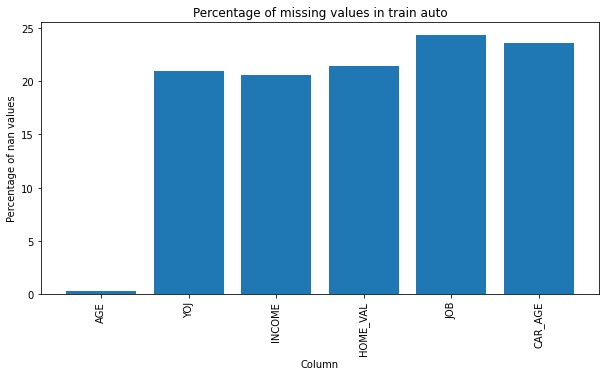

In [23]:
bar_plot(nan_values_percentage_new_train_auto,"Percentage of missing values in train auto","Column","Percentage of nan values")

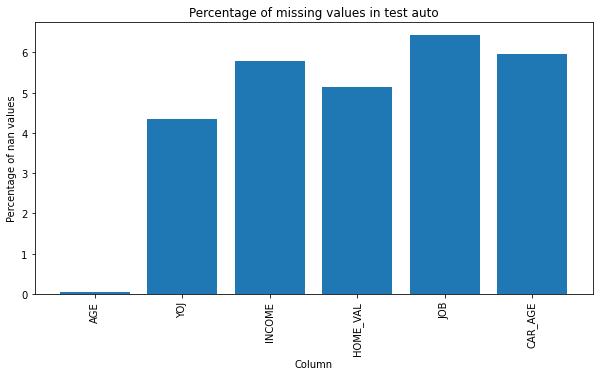

In [24]:
bar_plot(nan_values_percentage_new_test_auto,"Percentage of missing values in test auto","Column","Percentage of nan values")

In [25]:
# remove dollars from INCOME, HOME_VAL, BLUEBOOK, OLDCLAIM
def remove_dolars(df,column):
  df[column] = df[column].str.replace('$', '')
  df[column] = df[column].str.replace(',', '.')
  

def set_type(df,column,column_type):
  df[column] = df[column].astype(column_type)

remove_dolars(new_train_auto,"INCOME")
remove_dolars(new_test_auto,"INCOME")
set_type(new_train_auto,"INCOME",float)
set_type(new_test_auto,"INCOME",float)


remove_dolars(new_train_auto,"HOME_VAL")
remove_dolars(new_test_auto,"HOME_VAL")
set_type(new_train_auto,"HOME_VAL",float)
set_type(new_test_auto,"HOME_VAL",float)

remove_dolars(new_train_auto,"BLUEBOOK")
remove_dolars(new_test_auto,"BLUEBOOK")
set_type(new_train_auto,"BLUEBOOK",float)
set_type(new_test_auto,"BLUEBOOK",float)

remove_dolars(new_train_auto,"OLDCLAIM")
remove_dolars(new_test_auto,"OLDCLAIM")
set_type(new_train_auto,"OLDCLAIM",float)
set_type(new_test_auto,"OLDCLAIM",float)

In [26]:
# replace missing values of "job" column
new_train_auto["JOB"] = new_train_auto["JOB"].replace(np.NaN,"not mentioned")
new_test_auto["JOB"] = new_test_auto["JOB"].replace(np.NaN,"not mentioned")

In [27]:
new_train_auto.head(3)

,KIDSDRIV,AGE,HOMEKIDS,YOJ,INCOME,PARENT1,HOME_VAL,MSTATUS,SEX,EDUCATION,JOB,TRAVTIME,CAR_USE,BLUEBOOK,TIF,CAR_TYPE,RED_CAR,OLDCLAIM,CLM_FREQ,REVOKED,MVR_PTS,CAR_AGE,URBANICITY
INDEX,,,,,,,,,,,,,,,,,,,,,,,
1,0,60.0,0,11.0,67.349,0,0.000,0,M,PhD,Professional,14,Private,14.23,11,Minivan,1,4.461,2,0,3,18.0,Highly Urban/ Urban
2,0,43.0,0,11.0,91.449,0,257.252,0,M,z_High School,z_Blue Collar,22,Commercial,14.94,1,Minivan,1,0.000,0,0,0,1.0,Highly Urban/ Urban
4,0,35.0,1,10.0,16.039,0,124.191,1,z_F,z_High School,Clerical,5,Private,4.01,4,z_SUV,0,38.690,2,0,3,10.0,Highly Urban/ Urban


In [28]:
# replace missing values of the median
new_train_auto.fillna(new_train_auto.median(),inplace=True)
new_test_auto.fillna(new_test_auto.median(),inplace=True)

In [29]:
# display percentage of nan values in each df
print(nan_values_by_columns(new_train_auto))
print(nan_values_by_columns(new_test_auto))

{}
{}


In [30]:
# convert categorical variable into dummy variables

def convert_categorical_variable_into_dummy_variables(df,columns_list):
  res = []
  for c in columns_list:
    res.append(pd.get_dummies(df[c]))
  return res

# categorical columns
columns = ["SEX","EDUCATION","JOB","CAR_USE","CAR_TYPE","URBANICITY"]

dummies_train = convert_categorical_variable_into_dummy_variables(new_train_auto,columns)
dummies_test = convert_categorical_variable_into_dummy_variables(new_test_auto,columns)

# drop variables that have been converted to dummy variables
new_train_auto = new_train_auto.drop(columns,axis=1)
new_test_auto = new_test_auto.drop(columns,axis=1)

# concat dummies_train with train auto dataframe
train_df = [new_train_auto]
for df in dummies_train:
  train_df.append(df)
new_train_auto = pd.concat(train_df, axis=1)

# concat dummies_train with test auto dataframe
test_df = [new_test_auto]
for df in dummies_test:
  test_df.append(df)  
new_test_auto = pd.concat(test_df, axis=1)

In [31]:
new_train_auto.head()

,KIDSDRIV,AGE,HOMEKIDS,YOJ,INCOME,PARENT1,HOME_VAL,MSTATUS,TRAVTIME,BLUEBOOK,TIF,RED_CAR,OLDCLAIM,CLM_FREQ,REVOKED,MVR_PTS,CAR_AGE,M,z_F,<High School,Bachelors,Masters,PhD,z_High School,Clerical,Doctor,Home Maker,Lawyer,Manager,Professional,Student,not mentioned,z_Blue Collar,Commercial,Private,Minivan,Panel Truck,Pickup,Sports Car,Van,z_SUV,Highly Urban/ Urban,z_Highly Rural/ Rural
INDEX,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0,60.0,0,11.0,67.3490,0,0.000,0,14,14.23,11,1,4.461,2,0,3,18.0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,1,0
2,0,43.0,0,11.0,91.4490,0,257.252,0,22,14.94,1,1,0.000,0,0,0,1.0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,1,0
4,0,35.0,1,10.0,16.0390,0,124.191,1,5,4.01,4,0,38.690,2,0,3,10.0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0
5,0,51.0,0,14.0,54.7995,0,306.251,1,32,15.44,7,1,0.000,0,0,0,6.0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,1,0
6,0,50.0,0,11.0,114.9860,0,243.925,1,36,18.00,1,0,19.217,2,1,3,17.0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0


**4 -  Model classification & Evaluation**

Since we are dealing with a supervised classification case, we opted for the following ml algorithms : Logistic Regression, Naive Bayes, Decision tree. And then proceeded to compare their performance.

In [32]:
# function that fits the classifier using the training set, predicts the class of the records in the test sets and calculates the evaluation metrics
Metrics = [[]] 
def apply_classifiers(classifier,x_train,y_train,x_test,y_test,string, M):
  %%time      
  c = classifier
  c.fit(x_train, y_train)
  y_test_pred_classifier = c.predict(x_test)
  #print("y_test_pred_classifier",y_test_pred_classifier)
  confusion_matrix_classifier = confusion_matrix(y_test, y_test_pred_classifier)
  print("\n** Confusion matrix :\n\n", confusion_matrix_classifier)
  accuracy_test = c.score(x_test, y_test)
  accuracy_train = c.score(x_train, y_train)
  print('\n** Training set score: {:.4f}'.format(accuracy_train))
  print('\n** Test set score: {:.4f}'.format(accuracy_test))
  print("\n",classification_report(y_test,y_test_pred_classifier))
  ROC(y_test_pred_classifier,y_test,string)
  M.append([string,round(accuracy_test,2),round(recall_score(y_test,y_test_pred_classifier),2), round(precision_score(y_test,y_test_pred_classifier),2),round(f1_score(y_test,y_test_pred_classifier),2)])
  return classifier, y_test_pred_classifier

In [33]:
# ROC curve
def ROC(y_test_pred,y_test,string):
  roc_auc = roc_auc_score(y_test, y_test_pred)
  print('ROC AUC : {:.4f}'.format(roc_auc),"\n")
  fpr, tpr, thresholds = roc_curve(y_test, y_test_pred)
  plt.figure()
  plt.figure(figsize=(10,5))
  plt.plot(fpr, tpr, label= string + '(area = %0.2f)' % roc_auc)
  plt.plot([0, 1], [0, 1],'r--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver operating characteristic')
  plt.legend(loc="lower right")
  plt.savefig('Log_ROC')
  plt.show()

In [34]:
# split our train auto data frame into train dataset and test dataset
x_train, x_test, y_train, y_test = train_test_split(new_train_auto, output_target_flag, test_size=1/3, random_state=0)

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 6.91 µs

** Confusion matrix :

 [[1863  160]
 [ 478  220]]

** Training set score: 0.7669

** Test set score: 0.7655

               precision    recall  f1-score   support

           0       0.80      0.92      0.85      2023
           1       0.58      0.32      0.41       698

    accuracy                           0.77      2721
   macro avg       0.69      0.62      0.63      2721
weighted avg       0.74      0.77      0.74      2721

ROC AUC : 0.6180 



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


<Figure size 432x288 with 0 Axes>

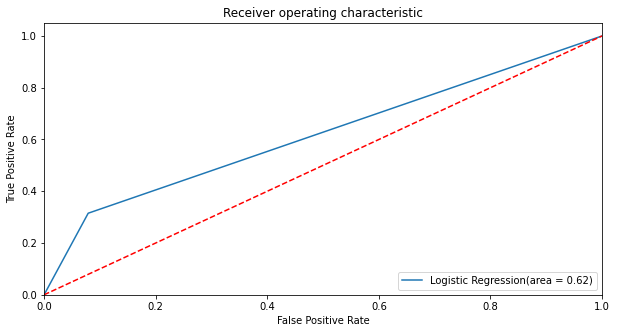

In [35]:
# apply Logistic Regression algorithm
classifier_LR, y_test_pred_LR = apply_classifiers(LogisticRegression(random_state=0),new_train_auto, output_target_flag,x_test,y_test,"Logistic Regression",Metrics)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 6.68 µs

** Confusion matrix :

 [[1433  590]
 [ 208  490]]

** Training set score: 0.7182

** Test set score: 0.7067

               precision    recall  f1-score   support

           0       0.87      0.71      0.78      2023
           1       0.45      0.70      0.55       698

    accuracy                           0.71      2721
   macro avg       0.66      0.71      0.67      2721
weighted avg       0.77      0.71      0.72      2721

ROC AUC : 0.7052 



<Figure size 432x288 with 0 Axes>

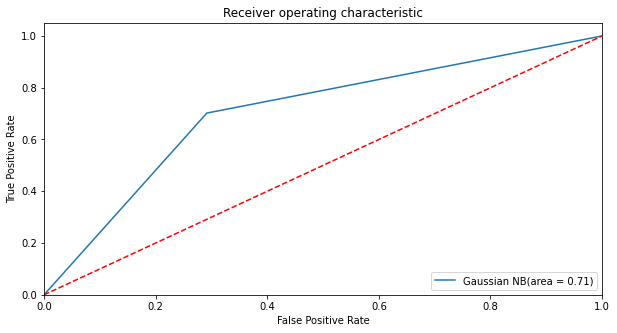

In [36]:
# apply Gaussian NB algorithm
classifier_BN, y_test_pred_BN = apply_classifiers(GaussianNB(),x_train,y_train,x_test,y_test,"Gaussian NB",Metrics)

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 6.91 µs

** Confusion matrix :

 [[1603  420]
 [ 357  341]]

** Training set score: 1.0000

** Test set score: 0.7144

               precision    recall  f1-score   support

           0       0.82      0.79      0.80      2023
           1       0.45      0.49      0.47       698

    accuracy                           0.71      2721
   macro avg       0.63      0.64      0.64      2721
weighted avg       0.72      0.71      0.72      2721

ROC AUC : 0.6405 



<Figure size 432x288 with 0 Axes>

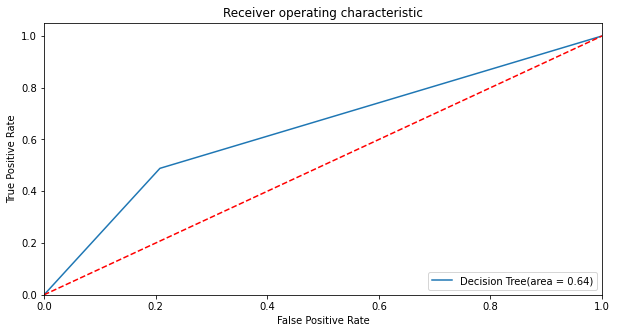

In [37]:
# apply Decision Tree algorithm
classifier_DT, y_test_pred_DT = apply_classifiers(DecisionTreeClassifier(),x_train, y_train,x_test,y_test,"Decision Tree",Metrics)

**5- Conclusion**

Taking into consideration all the models that we fitted, we will use the confusion matrix for their evaluation and to choose the model that performs best. We notice that the model with the highest performance is Naive Bayes since the accuracy is 0.71 with a precision of 0.87 for class 0 and a precision of 0.45 for class 1, and a recall of 0.71 for class 0 and 0.70 for class 1. Moreover, the AUC ROC that represents the area under the ROC curve is 0.70 meaning that it is a good classifier. So, we will be using the Naive Bayes  model to predict the target_flag values in the auto test dataset.

In [38]:
# predict target_flag of each record in test_auto
y_pred_target_flag = classifier_BN.predict(new_test_auto)

# fill test auto df with the predicted values of target flag column
def fill_test_data(df,column,y_pred):
  j = 0
  res = []
  for i in df.index:
    res.append(y_pred[j])  # fill missing values
    #df.loc[i] =  
    j = j + 1
  df[column] = res  

fill_test_data(new_test_auto,"TARGET_FLAG",y_pred_target_flag)

# display test auto dataframe
new_test_auto.head()

,KIDSDRIV,AGE,HOMEKIDS,YOJ,INCOME,PARENT1,HOME_VAL,MSTATUS,TRAVTIME,BLUEBOOK,TIF,RED_CAR,OLDCLAIM,CLM_FREQ,REVOKED,MVR_PTS,CAR_AGE,M,z_F,<High School,Bachelors,Masters,PhD,z_High School,Clerical,Doctor,Home Maker,Lawyer,Manager,Professional,Student,not mentioned,z_Blue Collar,Commercial,Private,Minivan,Panel Truck,Pickup,Sports Car,Van,z_SUV,Highly Urban/ Urban,z_Highly Rural/ Rural,TARGET_FLAG
INDEX,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
3,0,48.0,0,11.0,52.881,0,0.0,0,26,21.97,1,1,0.000,0,0,2,10.0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0
9,1,40.0,1,11.0,50.815,0,0.0,0,21,18.93,6,0,3.295,1,0,2,1.0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0
10,0,44.0,2,12.0,43.486,0,0.0,0,30,5.90,10,0,0.000,0,0,0,10.0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,1,0
18,0,35.0,2,11.0,21.204,0,0.0,0,74,9.23,6,0,0.000,0,1,0,4.0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0
21,0,59.0,0,12.0,87.460,0,0.0,0,45,15.42,1,1,44.857,2,0,4,1.0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0


In [39]:
# write the result in a csv file
new_test_auto.to_csv("/content/gdrive/My Drive/Datasets/test_technique/result.csv", index = True)